In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import matplotlib.pyplot as plt
import os.path
import os
%matplotlib inline

## Helper funcitons

In [2]:
imagepoints_file = "imagepoints.p"
calibration_file = "calibration.p"

test_image_path_white = "test_images/straight_lines2.jpg"
test_image_path_yellow = "test_images/test4.jpg"
test_image_path = test_image_path_yellow

def is_camera_calibrated():
    return os.path.isfile(calibration_file)

demo_mode = True
cb_cols = 9
cb_rows = 6
    

## Calibration

In [3]:
def get_points():
    fig, cells = plt.subplots(4,5, figsize=(30, 30))
    # fig.subplots_adjust(hspace = .2, wspace=.001)
    cells = cells.ravel()

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    print("Found", len(images), "images:", images)

    # Step through the list and search for chessboard corners
    for cnt, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        cells[cnt].imshow(img)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (cb_cols, cb_rows),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cells[cnt].axis('off')
            cells[cnt].imshow(img)
        else:
            print("Did not find corners for", fname)
            cells[cnt].imshow(img)

    cv2.destroyAllWindows()
   
    dist_pickle = {}
    dist_pickle["objpoints"] = objpoints
    dist_pickle["imgpoints"] = imgpoints
    pickle.dump( dist_pickle, open(imagepoints_file, "wb" ) )

    
def correct_distortion():
    # # Read in the saved objpoints and imgpoints
    dist_pickle = pickle.load( open( imagepoints_file, "rb" ) )
    objpoints = dist_pickle["objpoints"]
    imgpoints = dist_pickle["imgpoints"]

    img = cv2.imread('camera_cal/calibration3.jpg')

    def cal_undistort(img, objpoints, imgpoints):
        img_size = (img.shape[1], img.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        dst = cv2.undistort(img, mtx, dist, None, mtx)

        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open(calibration_file, "wb" ) )

        return dst

    undistorted = cal_undistort(img, objpoints, imgpoints)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

if not is_camera_calibrated():
    print("Calibrating the camera...")
    get_points()
    correct_distortion()
else:
    print("Camera already calibrated, so moving on.")

Camera already calibrated, so moving on.


## Example of undistorted image

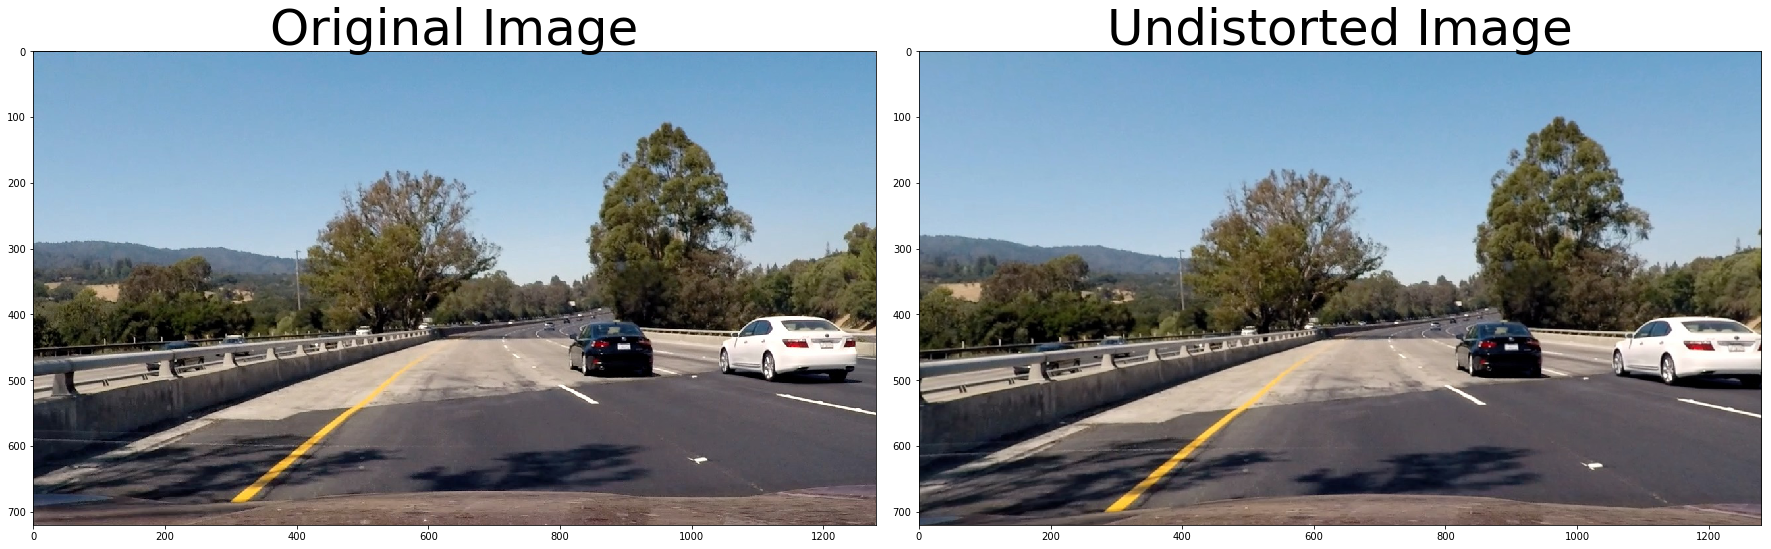

In [4]:
if demo_mode:
    dist_pickle = pickle.load( open( calibration_file, "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    img = cv2.imread(test_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = undistort(img, mtx, dist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Unwrapping

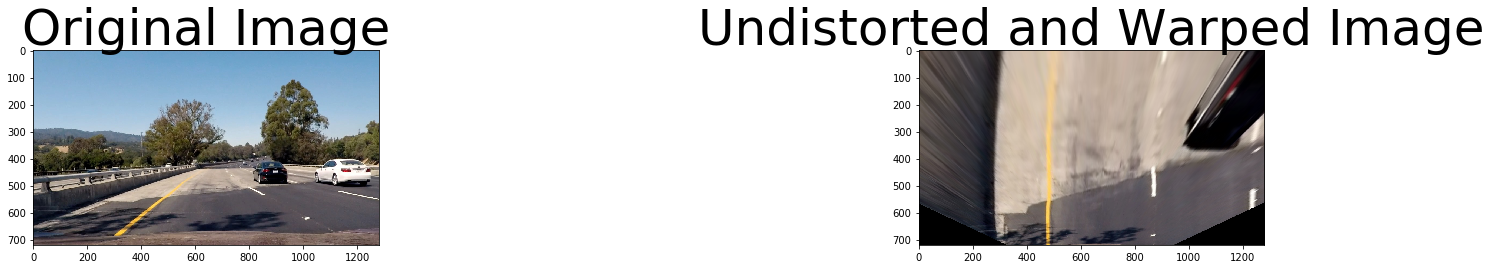

In [5]:

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( calibration_file, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# # Read in an image
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# nx = 8 # the number of inside corners in x
# ny = 6 # the number of inside corners in y

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    h,w = img.shape[:2]
    
    # NEED BETTER POINTS
#     psrc = np.float32([(580,464),
#                       (725,464), 
#                       (310,682), 
#                       (1100,682)])
#     pdst = np.float32([(450,0),
#                       (w-450,0),
#                       (450,h),
#                       (w-450,h)])
    
    psrc = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
    pdst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

    M = cv2.getPerspectiveTransform(psrc,pdst)
    warped = cv2.warpPerspective(dst, M, (w,h), flags=cv2.INTER_LINEAR)

    return warped, M


# cv2.line(img, (580, 464),(725,464),(200,255,155), 5)
# cv2.line(img, (725, 464),(1100,682),(200,255,155), 5)
# cv2.line(img, (1100, 682),(310,682),(200,255,155), 5)
# cv2.line(img, (310, 682),(580,464),(200,255,155), 5)

top_down, perspective_M = corners_unwarp(img, cb_cols, cb_rows, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 3))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Gradients

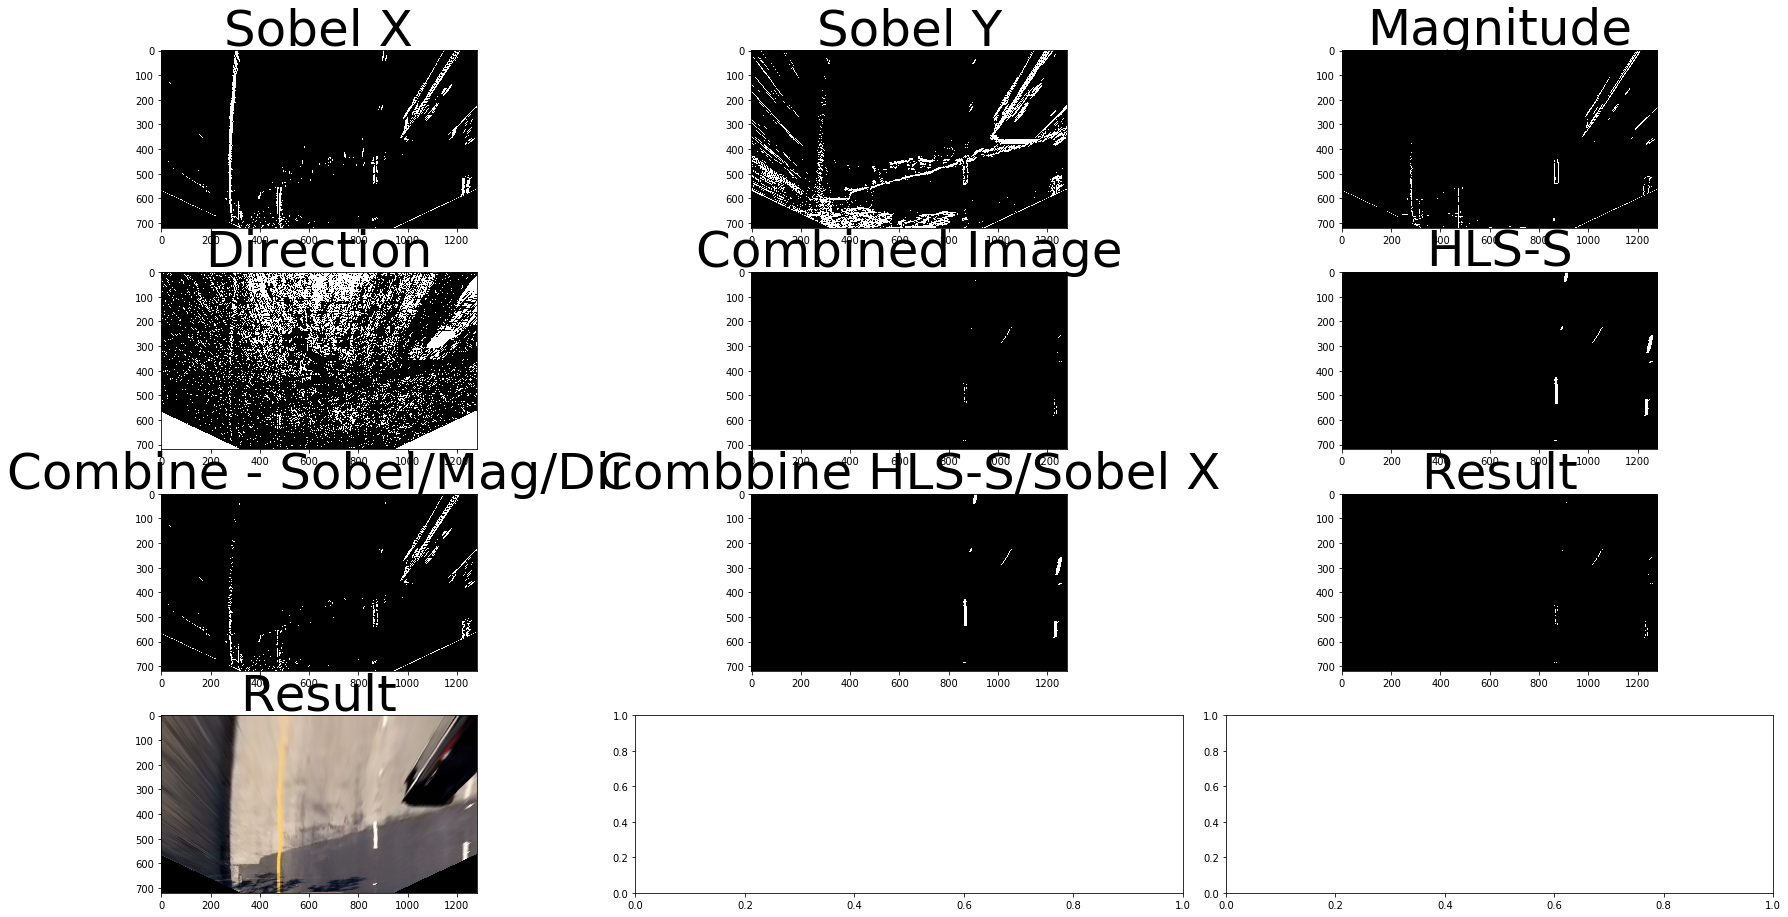

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,1]
    s_channel = s_channel*(255/np.max(s_channel))
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

top_down_hls = hls_select(top_down, thresh=(220, 255))

top_down_gs = top_down #cv2.cvtColor(top_down,cv2.COLOR_BGR2RGB)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(top_down_gs, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(top_down_gs, orient='y', sobel_kernel=ksize, thresh=(5, 255))
mag_binary = mag_thresh(top_down_gs, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(top_down, sobel_kernel=ksize, thresh=(0, 0.1))
# dir_min_thresh=(0,np.pi/2,0.01), 
#                  dir_max_thresh=(0,np.pi/2,0.01))
    
combined_sobel_dirmag = np.zeros_like(dir_binary)
combined_sobel_dirmag[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

combined_hls_sobelx = np.zeros_like(dir_binary)
combined_hls_sobelx[((gradx == 1) & (top_down_hls == 1))] = 1

combined = np.zeros_like(dir_binary)
combined[((combined_hls_sobelx == 1) & (combined_sobel_dirmag == 1))] = 1


f, axes = plt.subplots(4, 3, figsize=(24, 9))
f.tight_layout()

axes[0,0].imshow(gradx, cmap='gray')
axes[0,0].set_title('Sobel X', fontsize=50)

axes[0,1].imshow(grady, cmap='gray')
axes[0,1].set_title('Sobel Y', fontsize=50)

axes[0,2].imshow(mag_binary, cmap='gray')
axes[0,2].set_title('Magnitude', fontsize=50)

axes[1,0].imshow(dir_binary, cmap='gray')
axes[1,0].set_title('Direction', fontsize=50)

axes[1,1].imshow(combined, cmap='gray')
axes[1,1].set_title('Combined Image', fontsize=50)

axes[1,2].imshow(top_down_hls, cmap='gray')
axes[1,2].set_title('HLS-S', fontsize=50)

axes[2,0].imshow(combined_sobel_dirmag, cmap='gray')
axes[2,0].set_title('Combine - Sobel/Mag/Dir', fontsize=50)

axes[2,1].imshow(top_down_hls, cmap='gray')
axes[2,1].set_title('Combbine HLS-S/Sobel X', fontsize=50)

axes[2,2].imshow(combined, cmap='gray')
axes[2,2].set_title('Result', fontsize=50)

axes[3,0].imshow(top_down)
axes[3,0].set_title('Result', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=1.3, bottom=0.)